**Название проекта**

Стартап по продаже продуктов питания
_____
**Описание исследования.**
Я работаю в стартапе, который продаёт продукты питания


_____
**Цель исследования.**

Нужно разобраться, как ведут себя пользователи мобильного приложения

_____
**Задачи исследования.**
* унать как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
* исследовать результаты A/A/B-эксперимента
_____
**Исходные данные.**
    
Каждая запись в логе — это действие пользователя, или событие.
* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.



______

**Данное исследование разделим на несколько частей:**

* [Изучение общей информации](#main_info)
* [Предобработка данных](#preparing)
* [Изучение и проверка данных](#explore_data)
* [Изучение воронки событий](#event_funnel)
* [Изучение результатов эксперимента](#experiment_results)
* [Вывод](#summary)

<a id='main_info'></a>
## Изучение общей информации

**В этом шаге:**
* подключим библиотеки
* откроем и изучим файлы, необходимые для работы

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from plotly import graph_objects as go
import math
import numpy as np 

pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_colwidth', 0)

In [3]:
data = pd.read_csv('logs_exp.csv', sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [3]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
# выведем уникальные значения по всем столбцам - посмотрим есть ли на первый взгляд явные аномалии
def show_data_values(data):
    for col in data.columns:    
        try:
            values = sorted(data[col].unique())
            # если больше 10 значений, выведем только первые и последние 5
            if len(values) > 10:
                display (col, values[:5], values[-5:])
            else: display(col, values)
        except:
            display(f'После except: {col}', data[col].unique()) 

In [5]:
show_data_values(data)

'EventName'

['CartScreenAppear',
 'MainScreenAppear',
 'OffersScreenAppear',
 'PaymentScreenSuccessful',
 'Tutorial']

'DeviceIDHash'

[6888746892508752,
 6909561520679493,
 6922444491712477,
 7435777799948366,
 7702139951469979]

[9217594193087726423,
 9219463515465815368,
 9220879493065341500,
 9221926045299980007,
 9222603179720523844]

'EventTimestamp'

[1564029816, 1564053102, 1564054127, 1564055322, 1564055323]

[1565212345, 1565212439, 1565212483, 1565212498, 1565212517]

'ExpId'

[246, 247, 248]

<a id='preparing'></a>
## Предобработка данных

***На этом шаге:***
* Заменим названия столбцов на более удобные, зададим правильный тип столбцу со временем
* Проверим пропуски и дубликаты
* Добавим отдельный столбец дат

Заменим названия столбцов на более удобные, зададим правильный тип столбцу со временем

In [ ]:
data.columns = ['event_name', 'user_id', 'event_dt', 'exp_id']
data['event_dt'] = data['event_dt'].astype('datetime64[s]')
data.head()

Проверим пропуски

In [ ]:
data.isna().sum()

Проверим явные дубликаты

In [ ]:
data.duplicated().sum()

Удалим явные дубликаты

In [9]:
data = data[data.duplicated() == False]

Добавим отдельный столбец с датами событий

In [10]:
data['event_date'] = data['event_dt'].dt.date

***Вывод по шагу:***

Столбцы переименовали, тип столбца 'event_timestamp' исправлен, пропуски проверены, дубликаты удалены, отдельный столбец с датами событий добавлен

<a id='explore_data'></a>
## Изучение и проверка данных

***В этом шаге:***
* Узнаем сколько всего событий, пользователей и сколько в среднем событий приходится на пользователя
* Найдём максимальную и минимальную дату. Построим гистограмму по дате и времени. Определите, с какого момента данные полные и отбросим более старые. Узнаем данными за какой период времени мы располагаем на самом деле.
* Много ли событий и пользователей мы потеряли, отбросив старые данные? Проверим, что у нас есть пользователи из всех трёх экспериментальных групп


### Узнаем сколько всего событий, пользователей и сколько в среднем событий приходится на пользователя

In [11]:
events_count = len(data['event_name'])
print('Всего событий:', events_count)

Всего событий: 243713


In [12]:
users_count = data['user_id'].nunique()
print('Пользователей в логе:', users_count)

Пользователей в логе: 7551


In [13]:
print('В среднем событий приходится на пользователя:', round(events_count/users_count))

В среднем событий приходится на пользователя: 32


### Найдём максимальную и минимальную дату. Построим гистограмму по дате и времени. Определите, с какого момента данные полные и отбросим более старые. Узнаем данными за какой период времени мы располагаем на самом деле.

Найдём максимальную и минимальную дату

In [14]:
print('Минимальная дата:', data['event_dt'].min())
print('Максимальная дата:', data['event_dt'].max())
print('Доступный период:', data['event_dt'].max() - data['event_dt'].min())

Минимальная дата: 2019-07-25 04:43:36
Максимальная дата: 2019-08-07 21:15:17
Доступный период: 13 days 16:31:41


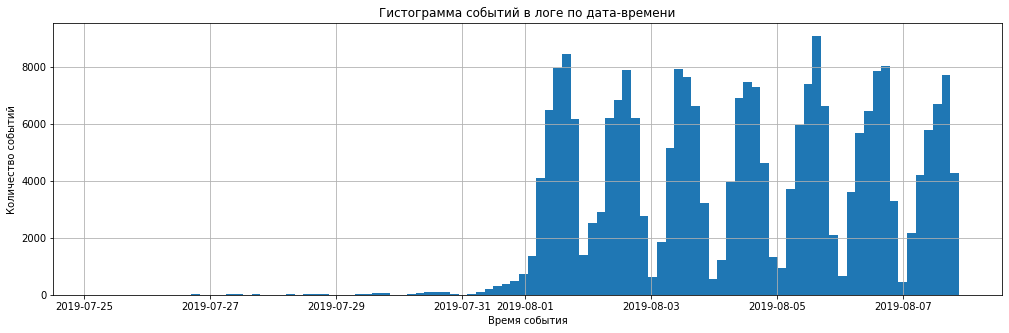

In [15]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(17)
ax.set_title('Гистограмма событий в логе по дата-времени') 
ax.set_xlabel('Время события')
ax.set_ylabel('Количество событий')

data['event_dt'].hist(bins=100);


***Вывод:*** Судя по гистограмме полные данные появляются только начиная с 2019-08-01

Отбросим начальный период с малым количеством данных. Определим доступный период после этого

In [16]:
data = data[data['event_dt'] >= '2019-08-01']
print('Доступный период:', data['event_dt'].max() - data['event_dt'].min())

Доступный период: 6 days 21:07:49


### Много ли событий и пользователей мы потеряли, отбросив старые данные? Проверим, что у вас есть пользователи из всех трёх экспериментальных групп

Узнаем сколько событий и пользователей мы потеряли, отбросив старые данные. Проверим, что у нас достаточно пользователей из всех трёх экспериментальных групп

In [17]:
print('Утраченных событий:', events_count - len(data['event_name']))
print('Утраченных пользователей:', users_count - data['user_id'].nunique())

print('Количество пользователей в каждой группе:\n', data.groupby('exp_id')['user_id'].nunique())

Утраченных событий: 2826
Утраченных пользователей: 17
Количество пользователей в каждой группе:
 exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64


***Вывод:*** Утраченных пользователей немного, их осталось достаточно в каждой группе, можем продолжать анализ.

**Вывод по шагу:** Определили доступный период с полными данными, отбросили период с неполными, определили, что утраченно данных немного и необходимых для теста осталось достаточно.

<a id='event_funnel'></a>
## Изучение воронки событий

***В этом шаге:***
* Посмотрим, какие события есть в логах, как часто они встречаются.
* Посчитаем, сколько пользователей совершали каждое из этих событий. Посчитаем долю пользователей, которые хоть раз совершали событие.
* Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку?
* По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). 
* На каком шаге теряется больше всего пользователей?
* Какая доля пользователей доходит от первого события до оплаты?



Посмотрим, какие события есть в логах, как часто они встречаются.

In [18]:
display('Виды событий и их количество', data['event_name'].value_counts())

'Виды событий и их количество'

MainScreenAppear           117328
OffersScreenAppear         46333 
CartScreenAppear           42303 
PaymentScreenSuccessful    33918 
Tutorial                   1005  
Name: event_name, dtype: int64

Уточним значения событий:

* MainScreenAppear - просмотр главной страницы - 117 328 раз
* OffersScreenAppear - переход на страницу предложений - 46 333 раза
* CartScreenAppear - переход на страницу "Корзина" - 42 303 раза
* PaymentScreenSuccessful - переход на страницу "Оплата произведена успешно" - 33 918 раз
* Tutorial - просмотр учебных шагов, которые показываются новым пользователям - 1 005 раз


Посчитаем, сколько пользователей совершали каждое из этих событий. А также посчитаем долю пользователей, хоть раз совершавших событие

In [19]:
# функция выводит таблицу с событиями, кол-вом пользователей,
# которые его вызвли, доля пользователей от общего числа пользователей
def users_counts_and_percents_of_event(in_data, title):   
    print(title)
    user_counts = in_data.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)

    user_counts_and_percents = pd.DataFrame({'Событие':user_counts.index, 'Количество пользователей':user_counts.values,\
                       'Доля от общего числа пользователей': user_counts.values/ in_data['user_id'].nunique()})
    display(user_counts_and_percents)
    return user_counts_and_percents

In [20]:
user_counts_and_percents = users_counts_and_percents_of_event(data, 'Количество пользователей, совершивших каждое из событий')

Количество пользователей, совершивших каждое из событий


,Событие,Количество пользователей,Доля от общего числа пользователей
0,MainScreenAppear,7419,0.98
1,OffersScreenAppear,4593,0.61
2,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


***Вывод:*** Как видим, даже основное событие выполнили не все пользователи, вероятно это из-за ошибок записи логов, либо из-за отсеянных нами частичных данных.
Можно предположить, что порядок событий такой же как в выыеденой таблице, за исключением 'Tutorial'. 'Tutorial' скорее всего идет сразу после главной, причем по желанию пользователя, поэтому при анализе воронки не будем его учитывать.

Построим воронку событий, посчитаем какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)

In [1]:
display('Воронка событий')
fig = go.Figure(go.Funnel(
    y = ["Просмотр главной страницы", "Переход на страницу предложений", "Переход в Корзину", "Успешное завершение оплаты"],
    x = user_counts_and_percents.iloc[:,1],#['Количество пользователей']
    textposition = "inside",
    textinfo = "value+percent previous",
    opacity = 1, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"]}))

fig.show()

'Воронка событий'

NameError: name 'go' is not defined

***Вывод:*** Самые большие потери при переходе с главной на страницу предложений. Возможно проблемы чисто технические.
Также, наведя мышь на нижнюю ступень, видим, что 47,7% пользователей доходит от первого события до оплаты.


***Вывод по шагу:*** Определены виды событий в логах, посчитано количество пользователей на каждое событие, и их доля от всех пользователей, определен порядок событий, построена воронка событий, найдено самое узкое место в воронке 

<a id='experiment_results'></a>
## Изучение результатов эксперимента

***В этом шаге:***
* Узнаем сколько пользователей в каждой экспериментальной группе?
* Проверим, находят ли статистические критерии разницу между выборками 246 и 247.
* Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий.
* Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой.
* Посчитаем, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат.

Узнаем сколько пользователей в каждой экспериментальной группе

In [22]:
trials = data.groupby('exp_id')['user_id'].nunique()
display('Количество пользователей в каждой экспериментальной группе:', trials)

'Количество пользователей в каждой экспериментальной группе:'

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

In [23]:
exp1 = data.query('exp_id == 246')
exp2 = data.query('exp_id == 247')
exp3 = data.query('exp_id == 248')

event_counts1 = exp1['event_name'].value_counts()
event_counts2 = exp2['event_name'].value_counts()

display(event_counts1)
display(event_counts2)

print(stats.ttest_ind(event_counts1, event_counts2, equal_var=False)[1])

MainScreenAppear           37676
OffersScreenAppear         14767
CartScreenAppear           14690
PaymentScreenSuccessful    11852
Tutorial                   317  
Name: event_name, dtype: int64

MainScreenAppear           39090
OffersScreenAppear         15179
CartScreenAppear           12434
PaymentScreenSuccessful    9981 
Tutorial                   338  
Name: event_name, dtype: int64

0.9601232817394973


Выведем по каждой группе количество пользователей совершивших каждое событие и их долю от общего числа пользователей

In [24]:
t1 = users_counts_and_percents_of_event(exp1, 'Количество пользователей на каждое событие в группе 1')
t2 = users_counts_and_percents_of_event(exp2, 'Количество пользователей на каждое событие в группе 2')
t3 = users_counts_and_percents_of_event(exp3, 'Количество пользователей на каждое событие в группе 3')

Количество пользователей на каждое событие в группе 1


,Событие,Количество пользователей,Доля от общего числа пользователей
0,MainScreenAppear,2450,0.99
1,OffersScreenAppear,1542,0.62
2,CartScreenAppear,1266,0.51
3,PaymentScreenSuccessful,1200,0.48
4,Tutorial,278,0.11


Количество пользователей на каждое событие в группе 2


,Событие,Количество пользователей,Доля от общего числа пользователей
0,MainScreenAppear,2476,0.99
1,OffersScreenAppear,1520,0.60
2,CartScreenAppear,1238,0.49
3,PaymentScreenSuccessful,1158,0.46
4,Tutorial,283,0.11


Количество пользователей на каждое событие в группе 3


,Событие,Количество пользователей,Доля от общего числа пользователей
0,MainScreenAppear,2493,0.98
1,OffersScreenAppear,1531,0.60
2,CartScreenAppear,1230,0.48
3,PaymentScreenSuccessful,1181,0.47
4,Tutorial,279,0.11


Проведем z-test для конверсий в группах 1 и 2

Напишем гипотезы:
* **Нулевая гипотеза 1:** в группах 1 и 2 конверсия пользователей на каждом шаге воронки ***одинакова***
* **Альтернативная гипотеза 1:**  в группах 1 и 2 конверсия пользователей на каждом шаге воронки ***различается***

Сделаем групповую таблицу 'Кол-во пользователей по событиям в каждой группе'. Также еще раз выведем 'Количество пользователей в каждой экспериментальной группе'

In [25]:
funnel = data.pivot_table(index='event_name', columns='exp_id', aggfunc={'user_id' : 'nunique'}).reset_index() 
funnel.columns = ['event_name', '246', '247', '248']
funnel = funnel.sort_values(by=funnel.columns[1], ascending=False)
display('Колчество пользователей по событиям в каждой группе (воронка событий по группам) (funnel)', funnel)
display('Количество пользователей в каждой экспериментальной группе (trials):', trials)

'Колчество пользователей по событиям в каждой группе (воронка событий по группам) (funnel)'

,event_name,246,247,248
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


'Количество пользователей в каждой экспериментальной группе (trials):'

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

In [26]:
def check_hypothesis(successes1, successes2, trials1, trials2):
    # пропорция успехов в первой группе:
    p1 = successes1/trials1
    # пропорция успехов во второй группе:
    p2 = successes2/trials2

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)

    # разница пропорций в датасетах
    difference = p1 - p2 
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    distr = stats.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

In [ ]:
print('Результат z-теста уровня конверсии пользователей на каждом шаге групп 1 и 2')

for i, row in funnel.iterrows():    
    print(row[0],"p-value =",   check_hypothesis(row[1], row[2], trials.values[0], trials.values[1]))

***Вывод:*** Конверсия в группах 1 и 2 вероятно одинакова, так как p-value двух выборок значительно выше 0,05 (от 0,25 до 0,94). Склоняемся к нулевой гипотезе. Похоже, что контрольные группы не имеют искаженных результатов и выбранный период достаточен для наших тестов.

Теперь можем провести z-test для конверсий в группах 1 и 3, а также 2 и 3

* **Нулевая гипотеза 2:** в группах 1 и 3 средний уровень конверсии пользователей на каждом шаге воронки ***одинаковый***
* **Альтернативная гипотеза 2:**  в группах 1 и 3 средний уровень конверсии пользователей на каждом шаге воронки ***различается***

In [28]:
print('Результат z-теста уровня конверсии пользователей на каждом шаге групп 1 и 3')

for i, row in funnel.iterrows():    
    print(row[0],"p-value =",   check_hypothesis(row[1], row[3], trials.values[0], trials.values[2]))

Результат z-теста уровня конверсии пользователей на каждом шаге групп 1 и 3
MainScreenAppear p-value = 0.2949721933554552
OffersScreenAppear p-value = 0.20836205402738917
CartScreenAppear p-value = 0.07842923237520116
PaymentScreenSuccessful p-value = 0.2122553275697796
Tutorial p-value = 0.8264294010087645


* **Нулевая гипотеза 3:** в группах 2 и 3 конверсии пользователей на каждом шаге воронки ***одинаковы***
* **Альтернативная гипотеза 3:**  в группах 2 и 3 конверсии пользователей на каждом шаге воронки ***различаются***

In [29]:
display('Результат z-теста уровня конверсии пользователей на каждом шаге групп 2 и 3')

for i, row in funnel.iterrows():    
    print(row[0],"p-value =",   check_hypothesis(row[2], row[3], trials.values[1], trials.values[2]))  

'Результат z-теста уровня конверсии пользователей на каждом шаге групп 2 и 3'

MainScreenAppear p-value = 0.4587053616621515
OffersScreenAppear p-value = 0.9197817830592261
CartScreenAppear p-value = 0.5786197879539783
PaymentScreenSuccessful p-value = 0.7373415053803964
Tutorial p-value = 0.765323922474501


***Вывод:*** Конверсии пользователей в группах 1 и 3, а также группах 2 и 3 вероятно одинаковы, так как по z-тесту p-value в обоих случаях очень высокий (от 0.21 и выше). Склоняемся к нулевым гипотезам

Теперь проведем сравнение 3й группы с объединенными группами 1 и 2

* **Нулевая гипотеза 4:** в группах 2 и 3 средний уровень конверсии пользователей на каждом шаге воронки ***одинаковый***
* **Альтернативная гипотеза 4:**  в группах 2 и 3 средний уровень конверсии пользователей на каждом шаге воронки ***различается***

Выведем еще раз таблицы для удобства наглядности написания кода

In [30]:
exp12 = data.query('exp_id == 246 or exp_id == 247')
trials_gr12 = exp12['user_id'].nunique()

users_by_exp12 = exp12.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)

print('Количество пользователей на каждое событие в совмещенной группе 1+2 ',users_by_exp12)

display('Колчество пользователей по событиям в каждой группе (воронка событий по группам)', funnel)
print('Общее пользователей в каждой группе\n', trials)

Количество пользователей на каждое событие в совмещенной группе 1+2  event_name
MainScreenAppear           4926
OffersScreenAppear         3062
CartScreenAppear           2504
PaymentScreenSuccessful    2358
Tutorial                   561 
Name: user_id, dtype: int64


'Колчество пользователей по событиям в каждой группе (воронка событий по группам)'

,event_name,246,247,248
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


Общее пользователей в каждой группе
 exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64


In [ ]:
print('Результат z-теста конверсий пользователей на каждом шаге совмезенной группы А1+А2 и группы B')

for i, row in funnel.iterrows():    
    print(row[0],"p-value =", check_hypothesis(users_by_exp12[row[0]], row[3], trials_gr12, trials.values[2]))


***Вывод:*** Конверсии по пользователей в совмещенной группе (А+А) и группе B вероятно одинаковы, так как p-value в обоих очень высокий (>0.62). Склоняемся к нулевым гипотезам

**Вывод по шагу:** Статистическое сравнение между выборками по трём группам произведено.

<a id='summary'></a>
## Вывод

**Выпишем выводы с предыдущих шагов**

* Доступный период для анализа с полными данными: с 2019-08-01 по 2019-08-07 (6 дней 21:07:49)
* Самые большие потери при переходе с главной на страницу предложений. Возможно проблемы чисто технические. 47,7% пользователей доходит от первого события до оплаты.

* Конверсия в группах 1 и 2 вероятно одинакова, так как p-value двух выборок значительно выше 0,05 (от 0,25 до 0,94). Склоняемся к нулевой гипотезе. Похоже, что контрольные группы не имеют искаженных результатов и выбранный период достаточен для наших тестов.

* Конверсии пользователей в группах 1 и 3, а также группах 2 и 3 вероятно одинаковы, так как по z-тесту p-value в обоих случаях очень высокий (от 0.21 и выше). Склоняемся к нулевым гипотезам

* Конверсии по пользователей в совмещенной группе (А+А) и группе B вероятно одинаковы, так как p-value в обоих очень высокий (>0.62). Склоняемся к нулевым гипотезам


**Общие выводы**
* Из доступного нам периода с высокой вероятностью подытожим, что эксперементальняе группы статистически одинаковы. Получается, что изменение шрифтов заметно не сказалось на пользовании сайтом.
* Также нужно детальней проверить причины потери 38% пользователей после посещения главной страницы.